# Imports

In [1]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, Matern, RationalQuadratic, RBF, WhiteKernel
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, KFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

# The data

The data is from electron microscopy - images of grpahene sheets. The typical image is $(256, 256)$ but we would like to take small patches of this and identify - is there a defect in the patch.

Lets go through a few of those things. Below we will look at 

* A full image
* A patch of an image with no defects
* A patch with a defect

### Full image

(256, 256)


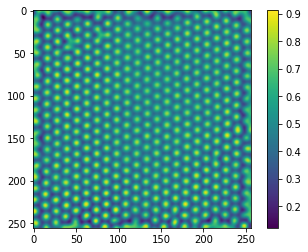

In [2]:
graphene = np.load('full-stack.npy') ## This has 180 different microgrpahs each (256, 256)
sample = np.squeeze(graphene[54])
print(sample.shape)
plt.imshow(sample)
plt.colorbar()

#### Description
The blue (high electron density) correspnds to atoms and the green correspnds to background.

You can see that in the middle of the sheet most of it is a pretty regular array of hexagons, this is what we exepct for the perfect lattice. You will also hopefully see some spots where the hexagon is broken. This many of these are the result of missing atom defects. 

Notice the edges look a bit weird too. This is standard, and we will generally ignore the edges when analysing.



### Perfect patch

There is a training dataset of perfect patches 

(2279, 48, 48)


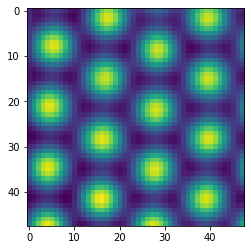

In [3]:
pp = np.load('./perfect_patches.npy')
perfect_sample = pp[0] 
print(pp.shape)
plt.imshow(perfect_sample)

### Defect patch

There is also a set of defective patches. Note - these are for testing only, not for training. I guess we could imagine training a classifier on these and the perfect patches - but that would be no fun :)

(32, 48, 48)


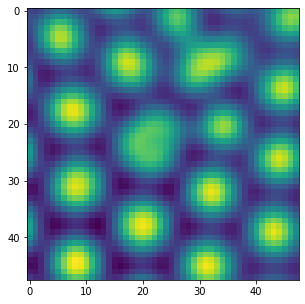

In [4]:
dp = np.load('./defect_patches.npy')
defect_sample = dp[0] 
print(dp.shape)

# Helper functions
The below fonctions help with the processing.

#### Model helper functions

In [5]:
def std(image) -> tuple:
    """Returns the standard deviations along the x and y axes.

    Args:
        image (Array): image to compute its standard deviations.

    Returns:
        tuple: (0-axis std, 1-axis std).
    """
    image1 = np.sum(image,axis=1)
    image0 = np.sum(image,axis=0)
    stdim0 = np.std(image0)
    stdim1 = np.std(image1)
    return (stdim0, stdim1)

### Image helper functions

In [6]:
def flip_horizontally(imgs):
    """Flips images horizontally.

    Args:
        imgs (nd.array): array of images to flip horizontally.

    Returns:
        nd.array: array of horizontally flipped images.
    """
    flipped = np.array([cv2.flip(img, 0) for img in imgs])
    return flipped

def flip_vertically(imgs):
    """Flips images vertically.

    Args:
        imgs (nd.array): array of images to flip vertically.

    Returns:
        nd.array: array of vertically flipped images.
    """
    flipped = np.array([cv2.flip(img, 1)  for img in imgs])
    return flipped

def blur(imgs, kernel: tuple = (5,5)):
    """Blurs images.

    Args:
        imgs (nd.array): array of images to blur.
        kernel (tuple): kernel tuple blurring the images.

    Returns:
        nd.array: array of blurred images.
    """
    blurred = np.array([cv2.blur(img, kernel) for img in imgs])
    return blurred

def augment(defect_imgs):
    """Augments the dataset by applying a series of transformations.

    Args:
        defect_imgs (np.array): array of images to augment.

    Returns:
        np.array: augmented array.
    """
    # Let's first apply some initial transformations.
    blurred = blur(defect_imgs)
    flip_h = flip_horizontally(defect_imgs)
    flip_v = flip_vertically(defect_imgs)
    flip_h_v = flip_horizontally(flip_v)
    b_h = blur(flip_h)
    b_v = blur(flip_v)
    b_h_v = blur(flip_h_v)
    data = [
        defect_imgs,
        blurred,
        flip_h,
        flip_v,
        flip_h_v,
        b_h,
        b_v,
        b_h_v,
            ]
    
    # Let's now apply mathematical transformations to the newly 
    # augmented data set.
    cosed = []
    sined = []
    taned = []
    exped = []
    
    for sub_data in data:
        cosed.append(np.cos(sub_data))
        sined.append(np.sin(sub_data))
        taned.append(np.tan(sub_data))
        exped.append(np.exp(sub_data))
        
    data = np.concatenate((*data, *cosed, *sined, *taned, *exped), axis=0)
    data = np.concatenate((data, blur(data, kernel=[7,7])), axis=0)
    
    return data

# Data Augmentation

In [7]:
limit = 2000
X_defect = augment(dp)[:limit]

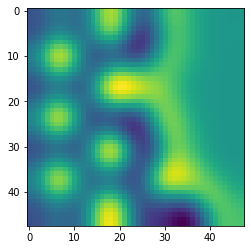

In [8]:
i = random.randint(0, X_defect.shape[0])
img = X_defect[i]
plt.imshow(img)

# Data Splitting
Here we are splitting the data into a:
- training set,
- validation set
- testing set.

In [9]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Perfect patches
X_perfect = pp[:limit]
y_perfect = np.zeros(len(X_perfect))
X_perfect_train, X_perfect_test, y_perfect_train, y_perfect_test = train_test_split(X_perfect, y_perfect, test_size=1 - train_ratio)
X_perfect_val, X_perfect_test, y_perfect_val, y_perfect_test = train_test_split(X_perfect_test, y_perfect_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_perfect_train.shape)
print(X_perfect_test.shape)
print(X_perfect_val.shape)

(1200, 48, 48)
(400, 48, 48)
(400, 48, 48)


In [10]:
# Defect patches

X_defect = X_defect[:limit]
y_defect = np.ones(len(X_defect))
X_defect_train, X_defect_test, y_defect_train, y_defect_test = train_test_split(X_defect, y_defect, test_size=1 - train_ratio)
X_defect_val, X_defect_test, y_defect_val, y_defect_test = train_test_split(X_defect_test, y_defect_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_defect_train.shape)
print(X_defect_test.shape)
print(X_defect_val.shape)


(1200, 48, 48)
(400, 48, 48)
(400, 48, 48)


### Training data set

In [11]:
# Concatenate the perfect and defect patches into one training and testing data sets.
X_train = np.concatenate((X_perfect_train, X_defect_train), axis = 0)
y_train = np.concatenate((y_perfect_train, y_defect_train), axis = 0)

# Shuffle training data set.
xy = list(zip(X_train, y_train)) # put labels with data in (data, label) tuple
random.shuffle(xy) # shuffle the tuples

# Unzip it.
X_train = []
y_train = []
for x, y in xy:
    X_train.append(x)
    y_train.append(y)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
print(f"X_train :\t {X_train.shape} | y_train :\t {y_train.shape}")

X_train :	 (2400, 48, 48) | y_train :	 (2400,)


### Testing data set

In [12]:
X_test = np.concatenate((X_perfect_test, X_defect_test), axis = 0)
y_test = np.concatenate((y_perfect_test, y_defect_test), axis = 0)

# Shuffle the testing data set.
xy = list(zip(X_test, y_test)) # put labels with data in (data, label) tuple
random.shuffle(xy) # shuffle the tuples

# Unzip it.
X_test = []
y_test = []
for x, y in xy:
    X_test.append(x)
    y_test.append(y)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
print(f"X_test :\t {X_test.shape} | y_test :\t {y_test.shape}")

X_test :	 (800, 48, 48) | y_test :	 (800,)


In [13]:
X_val = np.concatenate((X_perfect_val, X_defect_val), axis = 0)
y_val = np.concatenate((y_perfect_val, y_defect_val), axis = 0)

# Shuffle the validating data set.
xy = list(zip(X_val, y_val)) # put labels with data in (data, label) tuple
random.shuffle(xy) # shuffle the tuples

# Unzip it.
X_val = []
y_val = []
for x, y in xy:
    X_val.append(x)
    y_val.append(y)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
print(f"X_val :\t {X_val.shape} | y_val :\t {y_val.shape}")

X_val :	 (800, 48, 48) | y_val :	 (800,)


# Investigation standard deviations

(0.12360269, 0.0072767125, 24.593985, 24.593985, 3.0398827, 0.17896335)

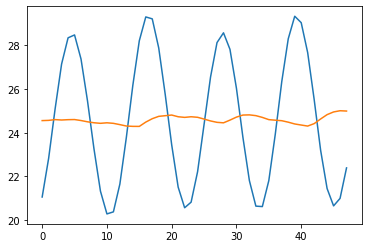

In [14]:
n1 = np.sum(perfect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(perfect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


(0.1249781, 0.03558564, 25.00563, 25.005632, 3.1251562, 0.8898415)

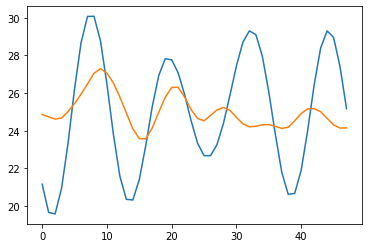

In [15]:
n1 = np.sum(defect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(defect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


In [16]:
perfect_patches_stds = []
defect_patches_stds = []
for _, img in enumerate(X_perfect_train):
    perfect_patches_stds.append(std(img))
for _, img in enumerate(X_defect_train):
    defect_patches_stds.append(std(img))


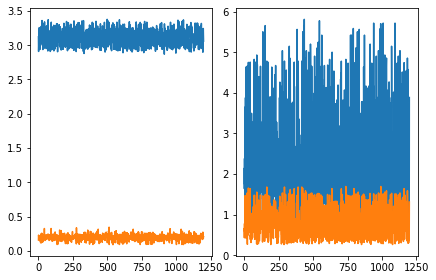

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(range(len(perfect_patches_stds)), [std0 for std0, std1 in perfect_patches_stds])
axes[0].plot(range(len(perfect_patches_stds)), [std1 for std0, std1 in perfect_patches_stds])
axes[1].plot(range(len(defect_patches_stds)), [std0 for std0, std1 in defect_patches_stds])
axes[1].plot(range(len(defect_patches_stds)), [std1 for std0, std1 in defect_patches_stds])
fig.tight_layout()

# Transforming the dataset upon investigation

In [18]:
X_train = np.array(
    [np.append(
        np.ndarray.flatten(x),
        std(x)) 
     for x in X_train]
    )

X_test = np.array(
    [np.append(
        np.ndarray.flatten(x),
        std(x)) 
     for x in X_test]
    )

X_val = np.array(
    [np.append(
        np.ndarray.flatten(x),
        std(x)) 
     for x in X_val]
    )

# Model

In [19]:
model = GaussianProcessClassifier()

# Grid search kernel for gaussian process classifier.
grid = dict()
grid['kernel'] = [RBF(), 
                  DotProduct(), 
                  Matern(),  
                  RationalQuadratic(), 
                  WhiteKernel(),
                  ]
cv = RepeatedStratifiedKFold(n_splits=10, 
                             n_repeats=3, 
                             random_state=1,
                             )
search = GridSearchCV(model, 
                      grid, 
                      scoring='accuracy', 
                      cv=cv, 
                      n_jobs=-1,
                      )
# Running the grid search on 100 inputs.
results = search.fit(
    X_val,
    y_val,
    )

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

### Summary

In [20]:
print(f'Best Mean Accuracy: {results.best_score_:.3f}')
print(f'Best Config: {results.best_params_}')

means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(f"\t{mean:.3f} with: {param}")

Best Mean Accuracy: 0.999
Best Config: {'kernel': RBF(length_scale=1)}
	0.999 with: {'kernel': RBF(length_scale=1)}
	nan with: {'kernel': DotProduct(sigma_0=1)}
	0.998 with: {'kernel': Matern(length_scale=1, nu=1.5)}
	0.999 with: {'kernel': RationalQuadratic(alpha=1, length_scale=1)}
	0.500 with: {'kernel': WhiteKernel(noise_level=1)}


Fitting the best model on the complete dataset.

In [21]:
model = GaussianProcessClassifier(RBF())
model.fit(X_train, y_train)

GaussianProcessClassifier(kernel=RBF(length_scale=1))

# Performance

In [22]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scorings = ['accuracy', 'neg_log_loss', 'roc_auc']
for scoring in scorings:
    results = cross_val_score(
        model, 
        X_test, 
        y_test, 
        cv=kfold, 
        scoring=scoring
        )
    print(f"{scoring} | mean: {results.mean():.3f} std: {results.std():.3f}")

/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


accuracy | mean: 1.000 std: 0.000


/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


neg_log_loss | mean: -0.192 std: 0.016


/usr/local/lib/python3.9/site-packages/sklearn/gaussian_process/_gpc.py:472: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


roc_auc | mean: 1.000 std: 0.000


In [23]:
predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print("Confusion matrix\n", matrix)

Confusion matrix
 [[400   0]
 [  0 400]]


In [24]:
report = classification_report(y_test, predicted)
print("Classification Report\n", report)

Classification Report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       400
         1.0       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

